<a href="https://colab.research.google.com/github/i-SanMartin/FastAI/blob/main/06_Multicat/BearClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWj5iVxx0OhA5joFDF-_s1PYVRut5AMHef1hNRLFO9EXnPjAFmHdd8s
Mounted at /content/gdrive


In [3]:
import shutil
from fastbook import *
from fastai.vision.widgets import *

In [4]:
!pip install -q jmd_imagescraper
from pathlib import Path
from jmd_imagescraper.core import *

In [6]:
pet_types = "grizzly bear", "black bear", "teddy bear"
path = Path().cwd()/"pets"

In [7]:
if path.exists():
    shutil.rmtree(path)

if not path.exists():
    path.mkdir()
    for o in pet_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = duckduckgo_search(path, o, o, max_results=100)

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Duckduckgo search: teddy bear


In [9]:
fns = get_image_files(path)
fns

(#300) [Path('/content/pets/black bear/056_2c652cd6.jpg'),Path('/content/pets/black bear/079_994effd1.jpg'),Path('/content/pets/black bear/014_0c8678e4.jpg'),Path('/content/pets/black bear/027_e1696e4c.jpg'),Path('/content/pets/black bear/031_4b6a19a6.jpg'),Path('/content/pets/black bear/060_b7488f7d.jpg'),Path('/content/pets/black bear/019_48b604d5.jpg'),Path('/content/pets/black bear/073_b5f916e7.jpg'),Path('/content/pets/black bear/029_12cf674b.jpg'),Path('/content/pets/black bear/030_f6543617.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [13]:
pets = pets.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pets.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


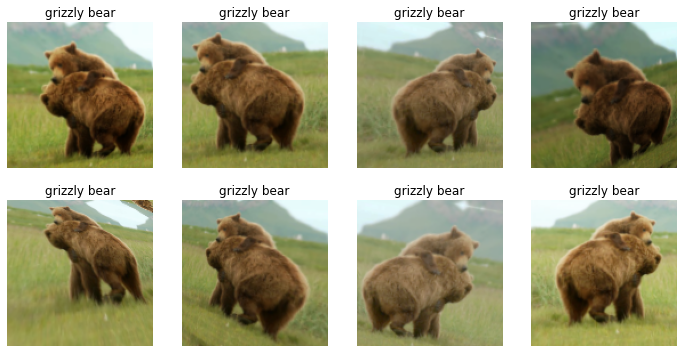

In [14]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [15]:
pets = pets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(path)